# Making sense of running data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
df = pd.read_csv("../input/run-or-walk/dataset.csv")

In [3]:
df.head(10)

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
5,2017-6-30,13:51:17:46806991,viktor,0,0,0.4044,-0.8056,-0.0956,0.6925,-0.2179,2.5750
6,2017-6-30,13:51:17:246767997,viktor,0,0,0.6320,-1.1290,-0.2982,0.0548,-0.1896,0.4473
7,2017-6-30,13:51:17:446569025,viktor,0,0,0.6670,-1.3503,-0.0880,-0.8094,-0.7938,-1.4348
8,2017-6-30,13:51:17:646152973,viktor,0,0,0.2704,-0.8633,0.1293,-0.4173,-0.1904,-2.6759
9,2017-6-30,13:51:17:846502006,viktor,0,0,0.4690,-1.0740,0.0219,0.0388,1.1491,1.6982


In [4]:
df.isnull().sum()

date              0
time              0
username          0
wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

In [5]:
num_walk = len(df[df["activity"] == 0].index)
num_run  = len(df[df["activity"] == 1].index)
print(f"There are {num_walk} walk activities")
print(f"There are {num_run} run activities")

There are 44223 walk activities
There are 44365 run activities


In [6]:
num_left   = len(df[df["wrist"] == 0].index)
num_right  = len(df[df["wrist"] == 1].index)
print(f"There are {num_left} left handed individuals")
print(f"There are {num_right} right handed individuals")

There are 42330 left handed individuals
There are 46258 right handed individuals


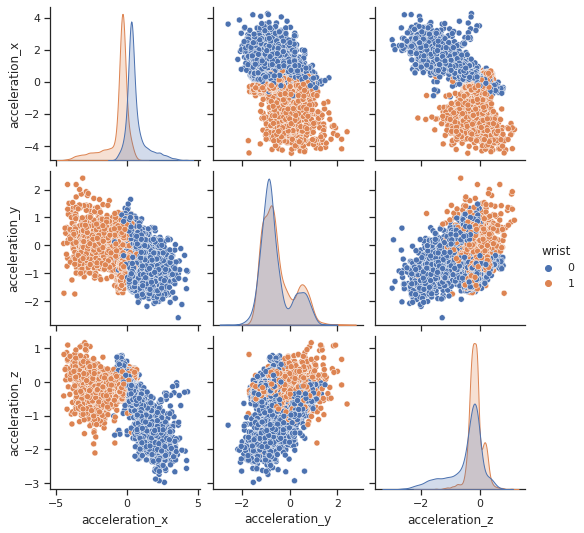

In [7]:
sns.pairplot(df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist"]].sample(frac=.1).reset_index(drop=True), hue="wrist")

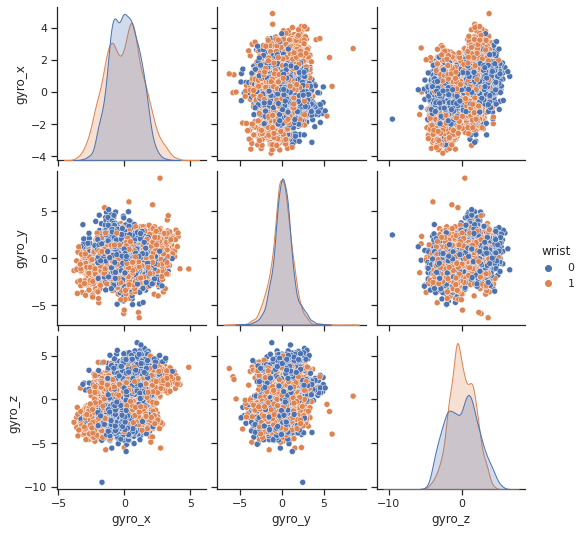

In [8]:
sns.pairplot(df[["gyro_x", "gyro_y", "gyro_z", "wrist"]].sample(frac=.1).reset_index(drop=True), hue = "wrist")

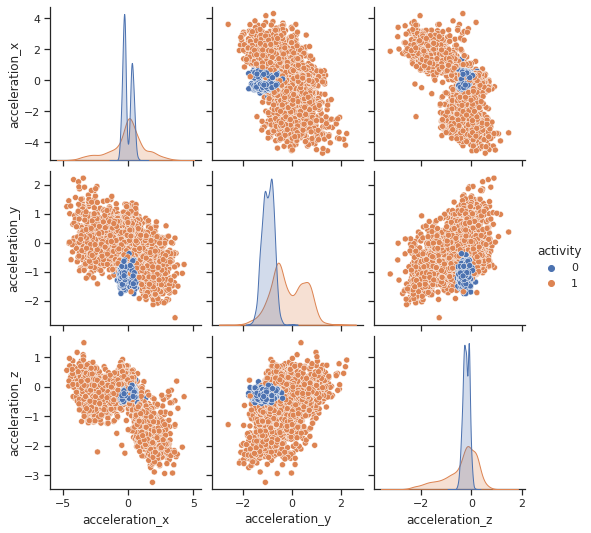

In [9]:
sns.pairplot(df[["acceleration_x", "acceleration_y", "acceleration_z", "activity"]].sample(frac=.1).reset_index(drop=True), hue="activity")

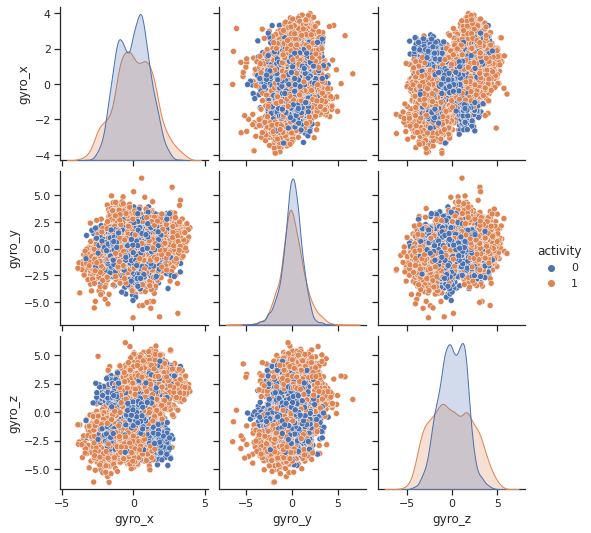

In [10]:
sns.pairplot(df[["gyro_x", "gyro_y", "gyro_z", "activity"]].sample(frac=.1).reset_index(drop=True), hue="activity")

In [11]:
acceleration_df = df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "activity"]].sample(frac=.1).reset_index(drop=True)

In [12]:
tsne = manifold.TSNE(n_components = 2, random_state=42)

transformed_data = tsne.fit_transform(acceleration_df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist"]]) 

In [13]:
tsne_df = pd.DataFrame(
    np.column_stack((transformed_data, acceleration_df["activity"])),
    columns=["x", "y", "targets"]
)
    
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


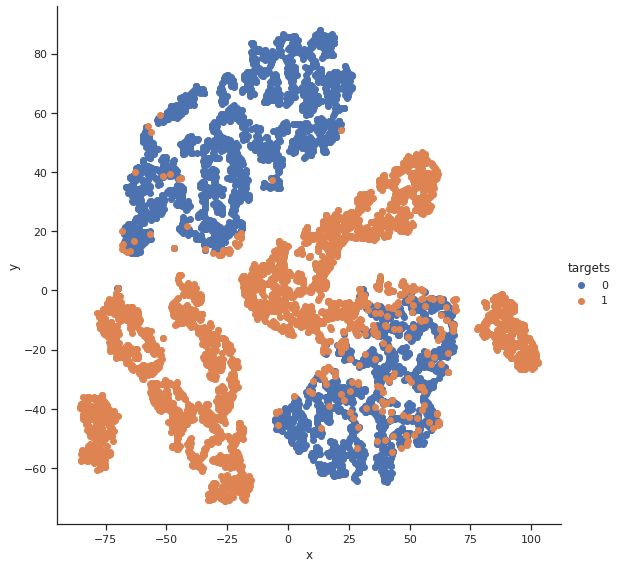

In [14]:
grid = sns.FacetGrid(tsne_df, hue="targets", size=8)
grid.map(plt.scatter, "x", "y").add_legend()

In [15]:
y = df["activity"].to_numpy()
x = df[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "gyro_x", "gyro_y", "gyro_z"]].to_numpy()


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)

In [17]:
def create_baseline():
    model = keras.Sequential(
    [
        layers.Dense(14, input_shape = (None,7), activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1,  activation="sigmoid"),
    ]
    )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
model = create_baseline()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 14)          112       
_________________________________________________________________
dense_1 (Dense)              (None, None, 20)          300       
_________________________________________________________________
dense_2 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_3 (Dense)              (None, None, 5)           55        
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           6         
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train, batch_size=128, epochs=15)

Epoch 1/15
464/464 [==============================] - 1s 1ms/step - loss: 0.3670 - accuracy: 0.8499
Epoch 2/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0629 - accuracy: 0.9787
Epoch 3/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0434 - accuracy: 0.9845
Epoch 4/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0344 - accuracy: 0.9888
Epoch 5/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0319 - accuracy: 0.9898
Epoch 6/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0301 - accuracy: 0.9908
Epoch 7/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0287 - accuracy: 0.9903
Epoch 8/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0280 - accuracy: 0.9908
Epoch 9/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0282 - accuracy: 0.9907
Epoch 10/15
464/464 [==============================] - 1s 1ms/step - loss: 0.0276 - accuracy: 0.9909

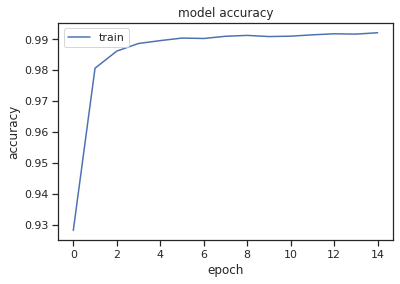

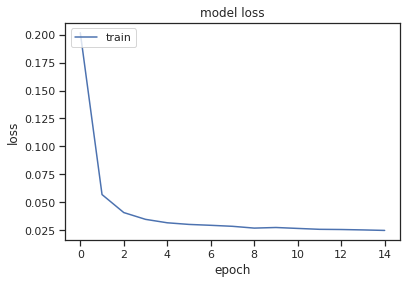

In [21]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
ynew = model.predict_classes(x_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=5, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/10
15946/15946 [==============================] - 20s 1ms/step - loss: 0.1217 - accuracy: 0.9471
Epoch 2/10
15946/15946 [==============================] - 19s 1ms/step - loss: 0.0289 - accuracy: 0.9902
Epoch 3/10
15946/15946 [==============================] - 20s 1ms/step - loss: 0.0273 - accuracy: 0.9910
Epoch 4/10
15946/15946 [==============================] - 19s 1ms/step - loss: 0.0249 - accuracy: 0.9916
Epoch 5/10
15946/15946 [==============================] - 20s 1ms/step - loss: 0.0233 - accuracy: 0.9918
Epoch 6/10
15946/15946 [==============================] - 19s 1ms/step - loss: 0.0239 - accuracy: 0.9917
Epoch 7/10
15946/15946 [==============================] - 20s 1ms/step - loss: 0.0244 - accuracy: 0.9916
Epoch 8/10
15946/15946 [==============================] - 19s 1ms/step - loss: 0.0227 - accuracy: 0.9921
Epoch 9/10
15946/15946 [==============================] - 19s 1ms/step - loss: 0.0234 - accuracy: 0.9919
Epoch 10/10
1772/1772 [==============================] 